In [1]:
import pandas as pd 
import pandas as pd 
from sklearn import preprocessing 
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from modutils import mod_calc
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
device = torch.device('cpu')
dataset  = 'wine.csv'
myFile = pd.read_csv(dataset, sep=',')
data = myFile.iloc[:, 0:len(myFile.columns) - 1]

In [2]:
import numpy as np
labels = []
my_data = np.genfromtxt(dataset, delimiter=',')
for column in my_data.T[len(myFile.columns) - 1]:
    if(column != len(myFile.columns)):
        labels.append(int(column))
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [3]:
# Normalize the data attributes for the Iris dataset.
from sklearn.datasets import load_iris
from sklearn import preprocessing
# separate the data from the target attributes
X = data.values[:,0:len(myFile.columns) - 1]
y = labels
# normalize the data attributes
normalized_X = preprocessing.scale(X)
print(X)

[[1.423000e+01 1.710000e+00 2.430000e+00 1.560000e+01 1.270000e+02
  2.800000e+00 3.060000e+00 2.800000e-01 2.290000e+00 5.640000e+00
  1.040000e+00 3.920000e+00 1.065000e+03]
 [1.320000e+01 1.780000e+00 2.140000e+00 1.120000e+01 1.000000e+02
  2.650000e+00 2.760000e+00 2.600000e-01 1.280000e+00 4.380000e+00
  1.050000e+00 3.400000e+00 1.050000e+03]
 [1.316000e+01 2.360000e+00 2.670000e+00 1.860000e+01 1.010000e+02
  2.800000e+00 3.240000e+00 3.000000e-01 2.810000e+00 5.680000e+00
  1.030000e+00 3.170000e+00 1.185000e+03]
 [1.437000e+01 1.950000e+00 2.500000e+00 1.680000e+01 1.130000e+02
  3.850000e+00 3.490000e+00 2.400000e-01 2.180000e+00 7.800000e+00
  8.600000e-01 3.450000e+00 1.480000e+03]
 [1.324000e+01 2.590000e+00 2.870000e+00 2.100000e+01 1.180000e+02
  2.800000e+00 2.690000e+00 3.900000e-01 1.820000e+00 4.320000e+00
  1.040000e+00 2.930000e+00 7.350000e+02]
 [1.420000e+01 1.760000e+00 2.450000e+00 1.520000e+01 1.120000e+02
  3.270000e+00 3.390000e+00 3.400000e-01 1.970000e+00

In [4]:
X = normalized_X

from scipy.spatial.distance import pdist,squareform
mat = squareform(pdist(normalized_X, metric='euclidean'))
A_hat = numpy.reciprocal(mat, where= mat > 0.0, out = np.zeros_like(mat))


In [5]:
CLASS = 3

In [6]:
class CDCGS(nn.Module):
  def __init__(self, A_hat, num_feat, num_hidden, CLASS):
    super(CDCGS, self).__init__()
    self.num_feat = num_feat
    self.num_hidden = num_hidden
    self.A_hat = A_hat
    self.W_0 = nn.Parameter(torch.ones(num_feat, CLASS))
    print(self.W_0.size())
    self.W_1 = nn.Parameter(torch.ones(num_feat, num_hidden))
    I = F.one_hot(torch.tensor(random.sample(range(0, num_feat), num_feat)), num_classes=num_feat)
    self.I = torch.tensor(I,dtype=torch.float)

  def forward(self, X, A_hat,temp):
    global featureSelector
    global weight_feature
    featureSelector = self.W_0
    results = torch.zeros(self.W_0.size())
    x = 300
    for i in range(x):
        results += F.gumbel_softmax(self.W_0,tau=temp,hard=False)
    weight_feature = results/x

    #H = torch.mm(X_tensor,self.W_1.T)
    H = torch.mm(torch.mm(weight_feature.T,X_tensor),weight_feature)
    H = torch.div(H, H.sum(axis=0))
    m = nn.Softmax(dim=0)
    return m(H)

num_hidden = len(A_hat[0])

model = CDCGS(A_hat, len(A_hat), num_hidden, CLASS).to(device)

def lossFn(output,exp): 
    return torch.sum((torch.diag(-torch.log(output))))

optimizer = optim.Adam(model.parameters(),lr=5e-2,weight_decay=0,betas=(0.5, 0.999), eps=1e-08)

X_tensor = torch.Tensor(A_hat).to(device)

loss_hist = []
acc_hist = []
temp = 4
logits=[]

for epoch in range(200):
    model.train()
    model.zero_grad()
    if(epoch == 75):
        temp = 0.75
    elif(epoch == 150):
        temp = 0.1
    output = model(X_tensor, 0, temp)
    #print(output)
    loss = lossFn(output,torch.diag(torch.ones(output.size()[0])))/CLASS
    loss_hist.append(loss.item())
    print('loss',epoch,loss)
    loss.backward()
    optimizer.step()


torch.Size([178, 3])
loss 0 tensor(1.0986, grad_fn=<DivBackward0>)


/opt/anaconda/envs/Deepak/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


loss 1 tensor(1.0986, grad_fn=<DivBackward0>)
loss 2 tensor(1.0986, grad_fn=<DivBackward0>)
loss 3 tensor(1.0986, grad_fn=<DivBackward0>)
loss 4 tensor(1.0986, grad_fn=<DivBackward0>)
loss 5 tensor(1.0986, grad_fn=<DivBackward0>)
loss 6 tensor(1.0985, grad_fn=<DivBackward0>)
loss 7 tensor(1.0985, grad_fn=<DivBackward0>)
loss 8 tensor(1.0984, grad_fn=<DivBackward0>)
loss 9 tensor(1.0982, grad_fn=<DivBackward0>)
loss 10 tensor(1.0980, grad_fn=<DivBackward0>)
loss 11 tensor(1.0978, grad_fn=<DivBackward0>)
loss 12 tensor(1.0975, grad_fn=<DivBackward0>)
loss 13 tensor(1.0971, grad_fn=<DivBackward0>)
loss 14 tensor(1.0967, grad_fn=<DivBackward0>)
loss 15 tensor(1.0962, grad_fn=<DivBackward0>)
loss 16 tensor(1.0957, grad_fn=<DivBackward0>)
loss 17 tensor(1.0951, grad_fn=<DivBackward0>)
loss 18 tensor(1.0944, grad_fn=<DivBackward0>)
loss 19 tensor(1.0937, grad_fn=<DivBackward0>)
loss 20 tensor(1.0930, grad_fn=<DivBackward0>)
loss 21 tensor(1.0921, grad_fn=<DivBackward0>)
loss 22 tensor(1.0912,

loss 174 tensor(0.9939, grad_fn=<DivBackward0>)
loss 175 tensor(0.9939, grad_fn=<DivBackward0>)
loss 176 tensor(0.9939, grad_fn=<DivBackward0>)
loss 177 tensor(0.9939, grad_fn=<DivBackward0>)
loss 178 tensor(0.9940, grad_fn=<DivBackward0>)
loss 179 tensor(0.9939, grad_fn=<DivBackward0>)
loss 180 tensor(0.9939, grad_fn=<DivBackward0>)
loss 181 tensor(0.9940, grad_fn=<DivBackward0>)
loss 182 tensor(0.9939, grad_fn=<DivBackward0>)
loss 183 tensor(0.9939, grad_fn=<DivBackward0>)
loss 184 tensor(0.9939, grad_fn=<DivBackward0>)
loss 185 tensor(0.9940, grad_fn=<DivBackward0>)
loss 186 tensor(0.9939, grad_fn=<DivBackward0>)
loss 187 tensor(0.9939, grad_fn=<DivBackward0>)
loss 188 tensor(0.9939, grad_fn=<DivBackward0>)
loss 189 tensor(0.9939, grad_fn=<DivBackward0>)
loss 190 tensor(0.9939, grad_fn=<DivBackward0>)
loss 191 tensor(0.9939, grad_fn=<DivBackward0>)
loss 192 tensor(0.9939, grad_fn=<DivBackward0>)
loss 193 tensor(0.9939, grad_fn=<DivBackward0>)
loss 194 tensor(0.9939, grad_fn=<DivBack

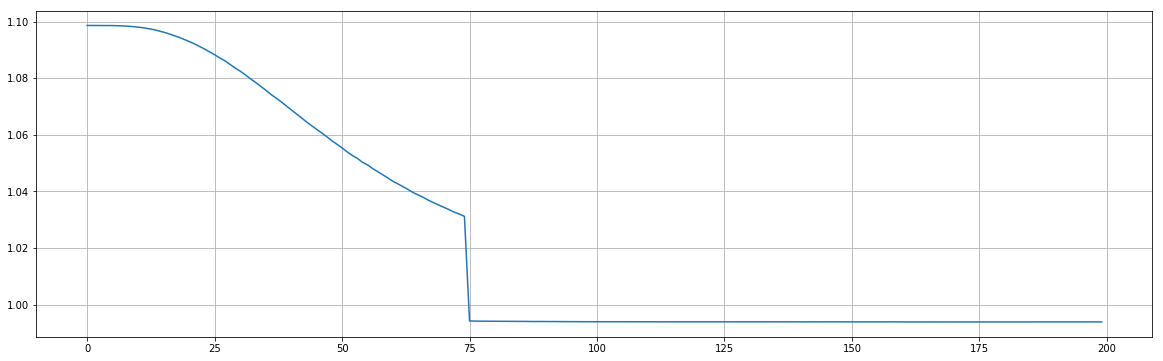

In [7]:
plt.figure(figsize=(20, 6))
plt.plot(loss_hist)
plt.grid(True)
plt.show()

In [8]:
gumbel_matrix = weight_feature.detach().max(dim=1)[1]
print(gumbel_matrix.numpy())
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
labels_true = y
#print(y)
labels_pred = gumbel_matrix.data.numpy()
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_rand_score
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
adjusted_rand_score 0.9325486492190683
normalized_mutual_info_score 0.9119703641235867
homogeneity_score 0.9146698403030901
completeness_score 0.9092867750497728
v_measure_score 0.9119703641235867


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


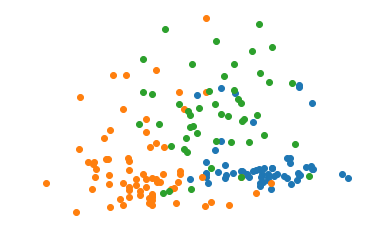

In [22]:
import matplotlib.pyplot as pyplot
labels_true = np.array(y)
print(labels_true)

clusters = numpy.unique(labels_true)
#clusters = np.array([0,1,2])
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = numpy.where(labels_true == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')
pyplot.show()


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


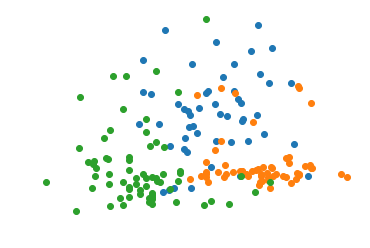

------------------------------------------------------
Data Points Clustering via Gumbel softmax
------------------------------------------------------
adjusted_rand_score 0.9325486492190683
normalized_mutual_info_score 0.9119703641235867
homogeneity_score 0.9146698403030901
completeness_score 0.9092867750497728
v_measure_score 0.9119703641235867


In [33]:
import matplotlib.pyplot as pyplot
gumbel_matrix = weight_feature.detach().max(dim=1)[1]
print(gumbel_matrix.numpy())
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
labels_true = y
#print(y)
labels_pred = gumbel_matrix.data.numpy()
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_rand_score
clusters = numpy.unique(labels_pred)
clusters = np.array([2,1,0])

for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = numpy.where(labels_pred == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('------------------------------------------------------')
print('Data Points Clustering via Gumbel softmax')
print('------------------------------------------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

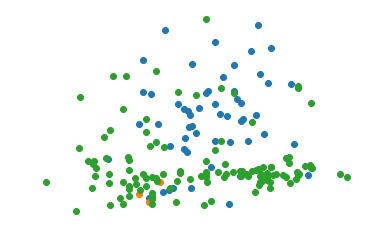

------------------
Spectral Clustering
------------------
adjusted_rand_score 0.4445688663091482
normalized_mutual_info_score 0.5724649437429142
homogeneity_score 0.46889464588878227
completeness_score 0.7347600797048867
v_measure_score 0.5724649437429142


In [48]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation,SpectralClustering, AgglomerativeClustering, OPTICS, Birch, DBSCAN, KMeans, MiniBatchKMeans, MeanShift
Num_class = CLASS
from numpy import where
from sklearn.datasets import make_classification, make_moons, make_gaussian_quantiles
from matplotlib import pyplot

model = SpectralClustering(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(labels_pred == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('------------------')
print('Spectral Clustering')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

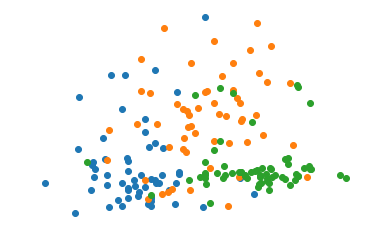

------------------
Birch
------------------
adjusted_rand_score 0.7899332213582837
normalized_mutual_info_score 0.7864652657004839
homogeneity_score 0.7904292718316542
completeness_score 0.7825408201875714
v_measure_score 0.7864652657004839


In [116]:
model = Birch(threshold=0.01, n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(labels_pred == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('------------------')
print('Birch')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

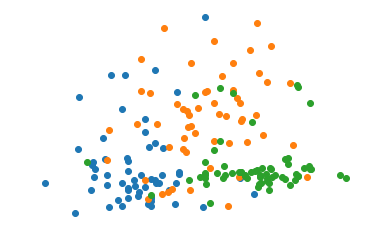

------------------
Agglomerative Clustering
------------------
adjusted_rand_score 0.7899332213582837
normalized_mutual_info_score 0.7864652657004839
homogeneity_score 0.7904292718316542
completeness_score 0.7825408201875714
v_measure_score 0.7864652657004839


In [159]:
model = AgglomerativeClustering(n_clusters=Num_class)
# fit model and predict clusters
labels_pred = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(labels_pred == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('------------------')
print('Agglomerative Clustering')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

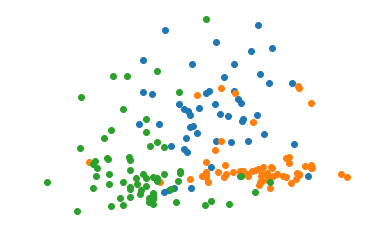

------------------
K Means
------------------
adjusted_rand_score 0.8974949815093207
normalized_mutual_info_score 0.875893534122307
homogeneity_score 0.8788432003662368
completeness_score 0.8729636016078732
v_measure_score 0.8758935341223071


In [147]:
model = KMeans(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(labels_pred == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('------------------')
print('K Means')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

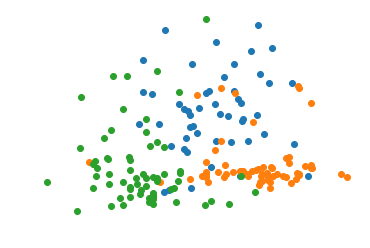

------------------
MiniBatch K-Means
------------------
adjusted_rand_score 0.8961288077970022
normalized_mutual_info_score 0.8770282178912252
homogeneity_score 0.8794980863507247
completeness_score 0.8745721827012318
v_measure_score 0.8770282178912253


In [150]:
model = MiniBatchKMeans(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(labels_pred == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('------------------')
print('MiniBatch K-Means')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

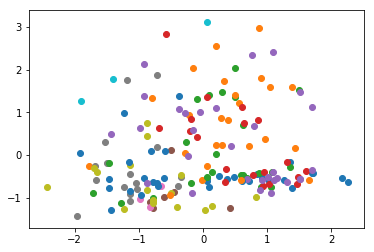

------------------
Affinity Propagation
------------------
adjusted_rand_score 0.24491255244382454
normalized_mutual_info_score 0.5039476691037833
homogeneity_score 0.8462664537925352
completeness_score 0.35880809640072525
v_measure_score 0.5039476691037833


In [17]:
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(labels_pred == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()
print('------------------')
print('Affinity Propagation')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))